### 🗂️ Column Descriptions (Airbnb Cleaned Dataset)

- `latitude`: Latitude coordinate of the listing
- `longitude`: Longitude coordinate of the listing
- `calculated_host_listings_count`: Number of listings the host has on Airbnb
- `availability_365`: Number of days per year the listing is available for booking
- `log_price`: Log-transformed price of the listing (used for modeling)
- `log_minimum_nights`: Log-transformed minimum number of nights required per booking
- `log_number_of_reviews`: Log-transformed total number of reviews the listing has
- `log_reviews_per_month`: Log-transformed average number of reviews received per month
- `neighbourhood_group_*`: One-hot encoded indicator for the listing’s borough (e.g., Manhattan, Brooklyn, etc.)
- `neighbourhood_grouped_*`: One-hot encoded top 10 frequent neighborhoods (others grouped as "Other")
- `room_type_*`: One-hot encoded type of room (Entire home/apt is the reference)
- `price_reversed`: Actual price per night, restored from `log_price` (added later for visualization)
- `room_type_label`: Readable room type reconstructed from encoded columns (used for plots only)


 Load Clean Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set(style="whitegrid")

# Load data
df = pd.read_csv("clean_airbnb_data.csv")

# Show first few rows
df.head()

,latitude,longitude,calculated_host_listings_count,availability_365,log_price,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,neighbourhood_grouped_Bushwick,neighbourhood_grouped_Crown Heights,neighbourhood_grouped_East Village,neighbourhood_grouped_Harlem,neighbourhood_grouped_Hell's Kitchen,neighbourhood_grouped_Midtown,neighbourhood_grouped_Other,neighbourhood_grouped_Upper East Side,neighbourhood_grouped_Upper West Side,neighbourhood_grouped_Williamsburg
0,40.64749,-73.97237,6,365,5.010635,0.693147,2.302585,0.190620,True,False,...,False,False,False,False,False,False,True,False,False,False
1,40.75362,-73.98377,2,355,5.420535,0.693147,3.828641,0.322083,False,True,...,False,False,False,False,False,True,False,False,False,False
2,40.80902,-73.94190,1,365,5.017280,1.386294,0.000000,0.000000,False,True,...,False,False,False,True,False,False,False,False,False,False
3,40.68514,-73.95976,1,194,4.499810,0.693147,5.602119,1.729884,True,False,...,False,False,False,False,False,False,True,False,False,False
4,40.79851,-73.94399,1,0,4.394449,2.397895,2.302585,0.095310,False,True,...,False,False,False,False,False,False,True,False,False,False


Distribution of log_price

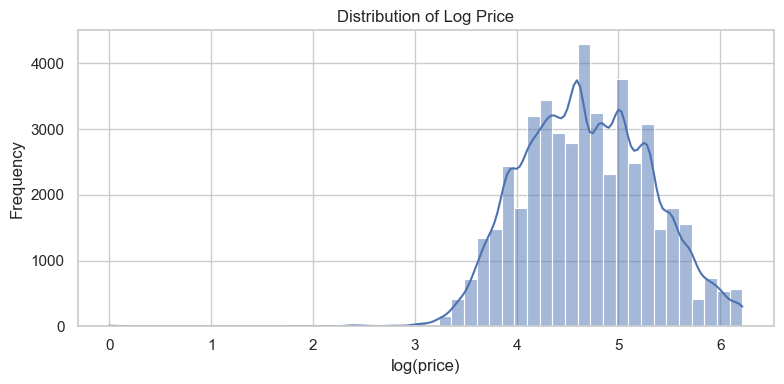

In [3]:
# Plot distribution of log_price
plt.figure(figsize=(8, 4))
sns.histplot(df['log_price'], bins=50, kde=True)
plt.title("Distribution of Log Price")
plt.xlabel("log(price)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

📌 The plot shows the distribution of Airbnb prices after log transformation (log(price + 1)):

The distribution is semi-normal and symmetric, which means the log transform worked well.

The highest density is between log(4) and log(5.5), i.e., prices roughly between $55 and $245.

The main peak appears around log(4.6) → approx. $100, indicating that most listings fall near this price point.

There’s a mild tail on both ends, but no extreme skew or outliers.

✅ This shape confirms that log_price is well-prepared for regression modeling, making it a stable target variable.

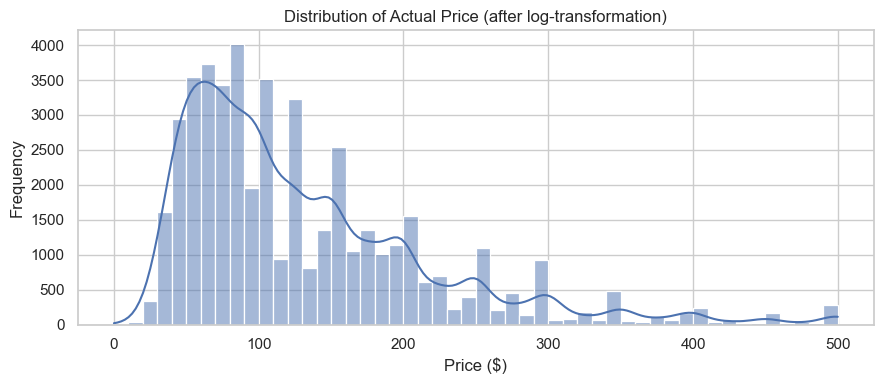

In [5]:
import numpy as np

# Inverse transform log_price to get actual price
df['price_reversed'] = np.expm1(df['log_price'])

# Plot histogram of actual price (after log-normalization)
plt.figure(figsize=(9, 4))
sns.histplot(df['price_reversed'], bins=50, kde=True)
plt.title("Distribution of Actual Price (after log-transformation)")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In this block, we converted log_price back to the original price scale using:
price = exp(log_price) - 1
📌 The purpose:

To display prices in actual dollar values, which are more intuitive

While still preserving the smoother distribution we achieved using log transformation

This makes the visual more readable for non-technical stakeholders or presentations

📍 Instead of showing axis ticks like log(4.6), we now directly see $100–$250, which is easier to interpret and communicate.

Room Type vs Price (Boxplot, in Real Scale)

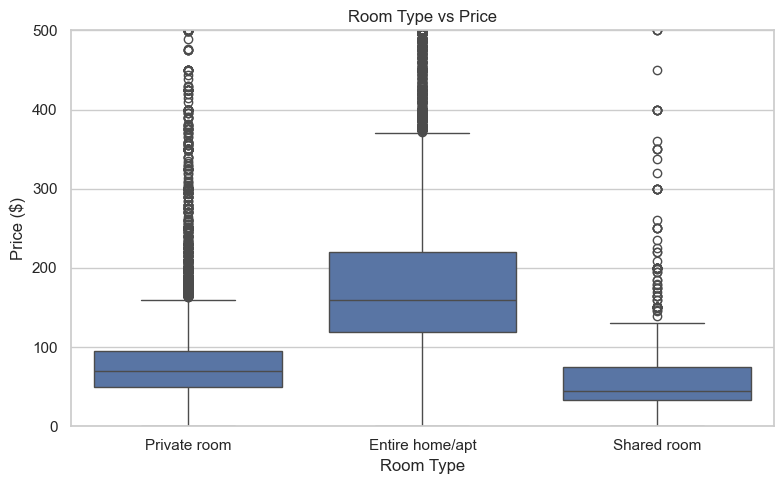

In [9]:
import numpy as np

# First, create a new column: actual price from log_price
df['price_reversed'] = np.expm1(df['log_price'])

# Create a readable room_type column from the encoded binary columns
df['room_type_label'] = df.apply(
    lambda row: 'Private room' if row['room_type_Private room'] == 1
    else 'Shared room' if row['room_type_Shared room'] == 1
    else 'Entire home/apt', axis=1)

# Plot boxplot: room type vs actual price
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='room_type_label', y='price_reversed')
plt.title('Room Type vs Price')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.ylim(0, 500)  # cap for visibility
plt.tight_layout()
plt.show()


📌 This boxplot shows how room type influences actual listing prices on Airbnb:

🏠 Entire home/apt:
The most expensive option.

Median price is around $160–$180.

Very wide spread with many listings near the upper limit ($500).

Makes sense as guests rent the entire space.

🛏️ Private room:
A mid-range choice.

Median price is around $70–$80.

More compact distribution but has many outliers (some private rooms are overpriced).

👥 Shared room:
Lowest price range.

Median price close to $60 or less.

Similar pattern to private room but lower.

📍 Key Insight:
Room type is a strong predictor of price and should definitely be included in modeling.

##  Borough-Level Price Analysis

This section explores how average Airbnb prices vary across different boroughs in New York City.  
By converting one-hot encoded borough indicators into a readable label, we group the data to analyze the typical nightly price in each area.


In [13]:
# Create human-readable borough label from one-hot columns
def get_borough(row):
    if row['neighbourhood_group_Manhattan'] == 1:
        return 'Manhattan'
    elif row['neighbourhood_group_Brooklyn'] == 1:
        return 'Brooklyn'
    elif row['neighbourhood_group_Queens'] == 1:
        return 'Queens'
    elif row['neighbourhood_group_Staten Island'] == 1:
        return 'Staten Island'
    else:
        return 'Bronx'  # assumed as the baseline dropped in encoding

df['borough'] = df.apply(get_borough, axis=1)


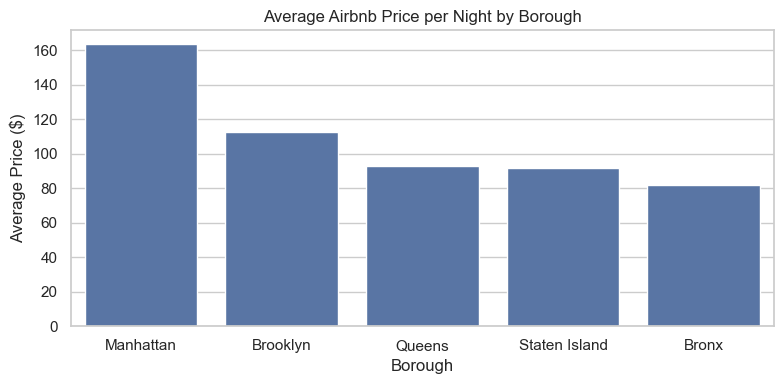

In [15]:
# Average price per borough
import numpy as np

borough_price = df.groupby('borough')['price_reversed'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=borough_price.index, y=borough_price.values)
plt.title("Average Airbnb Price per Night by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Price ($)")
plt.tight_layout()
plt.show()


📊 This barplot shows the average nightly price for Airbnb listings across New York City boroughs:

🗽 Manhattan:
The most expensive borough, with an average price of around $160/night

Likely due to central location, tourism, accessibility, and premium properties.

🏙️ Brooklyn:
Second-highest, averaging around $110/night

Known for trendier neighborhoods and growing demand.

🏘️ Queens, 🏝️ Staten Island, and 🏚️ Bronx:
Lower average prices in the $80–$95 range

More residential or remote areas, ideal for budget travelers.

📍 Key Insight:
Geographic location is a major driver of Airbnb pricing and must be considered in any pricing model.

##  Guest Engagement by Room Type

In this section, we analyze how actively guests interact with different types of Airbnb listings,  
based on the number of reviews. A higher number of reviews may indicate greater popularity, affordability, or availability.

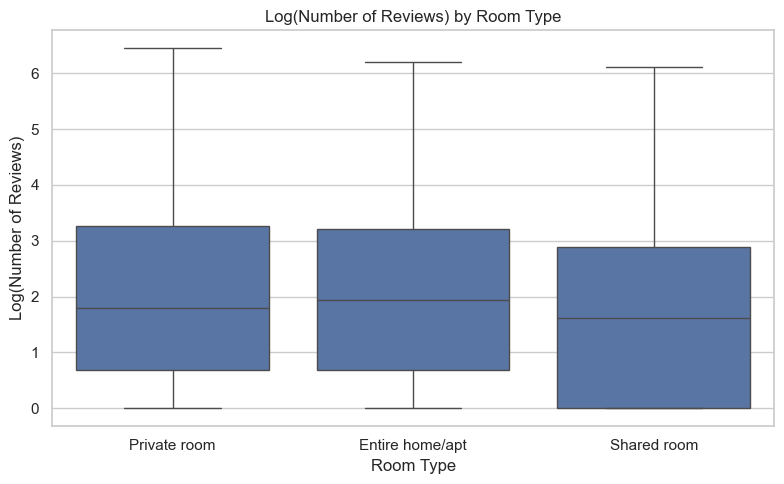

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='room_type_label', y='log_number_of_reviews')
plt.title("Log(Number of Reviews) by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Log(Number of Reviews)")
plt.tight_layout()
plt.show()


📊 This boxplot shows the log-transformed number of reviews per room type:

🔹 Private Room:
Median around log(1.8) → approx. 6–7 reviews

Widest spread with many high-review listings

Indicates high availability and popularity

🔹 Entire Home/Apt:
Similar distribution to private rooms but slightly lower spread on the high end

Suggests varied engagement across listings

🔹 Shared Room:
Lowest median and narrowest range

Suggests lower guest activity or fewer bookings

📍 Insight: Room type affects not just price, but also guest engagement levels. Private rooms tend to get the most interaction.



Minimum Nights vs Price

This section explores whether the minimum number of nights required for booking affects the price of Airbnb listings.  
We'll use a scatter plot to detect possible trends or clusters.

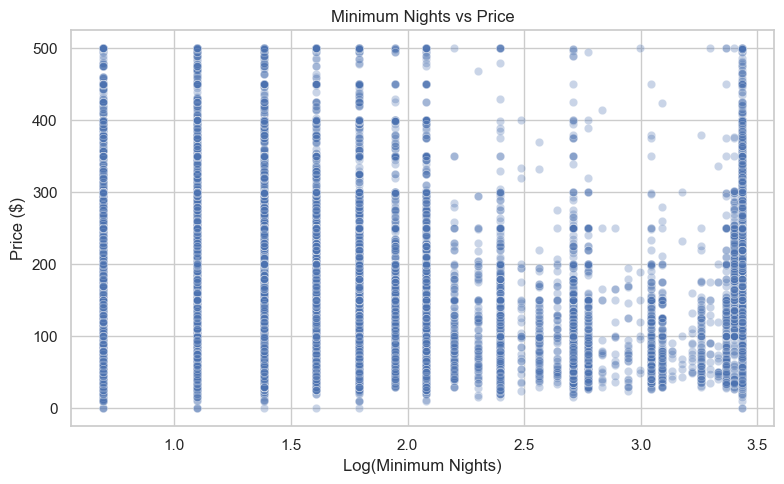

In [19]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='log_minimum_nights', y='price_reversed', alpha=0.3)
plt.title("Minimum Nights vs Price")
plt.xlabel("Log(Minimum Nights)")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()


📊 This scatter plot shows the relationship between log(minimum_nights) and nightly price:

There is no clear linear pattern between the two variables.

A high density of listings have minimum_nights = 1, covering a wide price range.

Listings with longer minimum stays (e.g., log(3) ≈ 20 nights) also span low to high prices.

The variation suggests:

Some hosts discount for long stays

Others charge more (e.g., luxury or niche accommodations)

📌 Key Insight: Minimum nights alone is not a strong predictor of price — might only matter when combined with other variables like location or room type.

Availability vs Price

Does having a listing available for more days in a year lead to higher pricing?  
Here we analyze the relationship between `availability_365` and `price_reversed`.

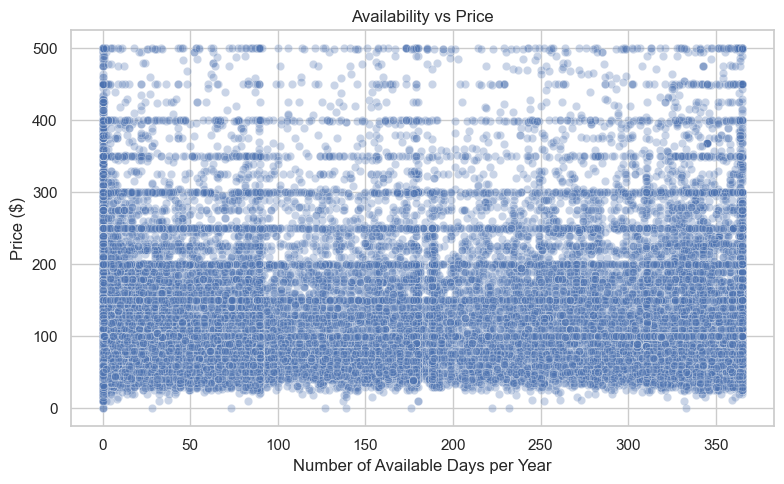

In [21]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='availability_365', y='price_reversed', alpha=0.3)
plt.title("Availability vs Price")
plt.xlabel("Number of Available Days per Year")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()


📊 This scatter plot examines the relationship between availability_365 (number of active days per year) and nightly price:

There is no clear or strong correlation between availability and price.

Listings available for the full year (365 days) span a wide price range — from low to premium.

Similarly, listings with limited availability can be either cheap or expensive.

This suggests:

Some hosts only list during high-demand periods but charge more.

Others aim for year-round bookings at a lower rate.

📌 Conclusion:
availability_365 on its own is not a strong predictor of price but may have value when combined with other features.

Top Features Correlated with Price

To understand which features most influence the listing price, we compute the correlation between each numeric feature and `log_price`,  
and rank them to identify the most impactful variables.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27820\751738956.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_price.values, y=correlation_with_price.index, palette='coolwarm')


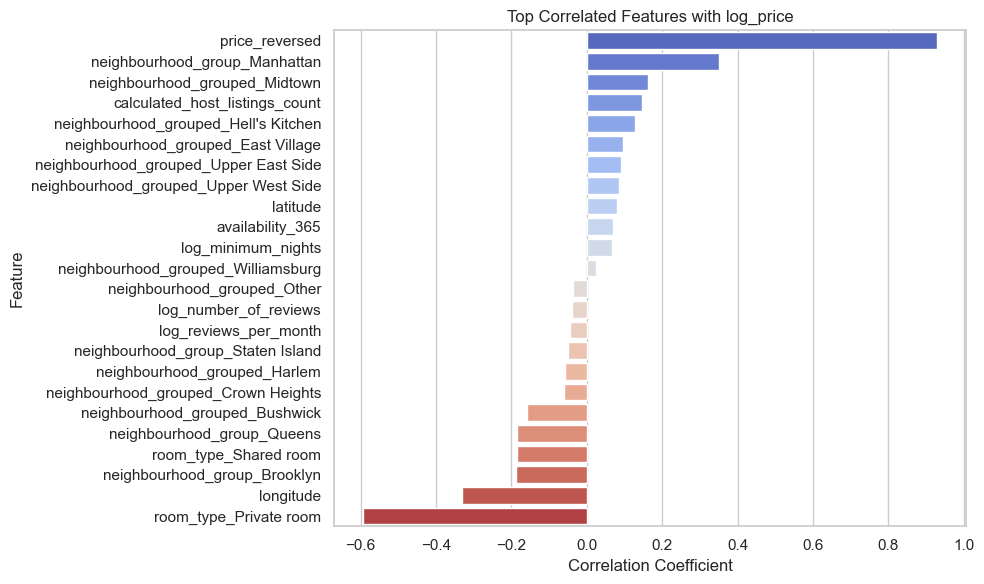

In [23]:
# Compute correlation with log_price
correlation_with_price = df.corr(numeric_only=True)['log_price'].sort_values(ascending=False)

# Drop self-correlation
correlation_with_price = correlation_with_price.drop('log_price')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_price.values, y=correlation_with_price.index, palette='coolwarm')
plt.title("Top Correlated Features with log_price")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Positively Correlated Features (Drive Price Up):

| Feature                                                 | Insight                                                    |
| ------------------------------------------------------- | ---------------------------------------------------------- |
| `neighbourhood_group_Manhattan`                         | Listings in Manhattan are typically more expensive.        |
| `neighbourhood_grouped_Midtown`, `Hell's Kitchen`, etc. | Central neighborhoods push prices up.                      |
| `calculated_host_listings_count`                        | Professional hosts with many listings tend to charge more. |
| `latitude`, `availability_365`                          | Location & year-round availability have modest effects.    |


Negatively Correlated Features (Associated with Lower Prices):


| Feature                                                   | Insight                                                       |
| --------------------------------------------------------- | ------------------------------------------------------------- |
| `room_type_Private room` and `room_type_Shared room`      | These are cheaper than entire homes, as expected.             |
| `neighbourhood_group_Brooklyn`, `Queens`, `Staten Island` | Generally lower-cost boroughs                                 |
| `log_reviews_per_month`, `log_number_of_reviews`          | Surprisingly, more active listings may not be more expensive. |


Features like room type and location dominate price prediction — while engagement metrics(log_number_of_reviews,log_reviews_per_month,availability_365) play a weaker role.



Insight Summary Board

This section summarizes the most important insights discovered through our data exploration and visual analysis.  
It helps both technical and non-technical stakeholders understand the key drivers behind Airbnb pricing in NYC.

In [ ]:
| Insight Category        | Key Finding                                                                 |
|-------------------------|------------------------------------------------------------------------------|
|  Most Expensive Area   | Manhattan listings have the highest average prices                         |
|  Cheapest Option       | Shared and Private rooms are significantly cheaper than entire homes       |
|  Guest Behavior        | Private rooms receive the most reviews, indicating high engagement          |
|  Location Impact       | Neighborhood and borough are strong predictors of price                     |
|  Availability          | No clear pattern between availability and price                             |
|  Minimum Stay         | Listings with longer minimum nights do not consistently cost more           |
|  Price Distribution    | Log-transformed prices follow a near-normal distribution                    |
|  Feature Importance     | Room type and location have the strongest correlation with price            |
|  Weak Predictors       | Review count and availability have weak correlation with price              |
